In [174]:
!pip install prophet

In [175]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from prophet import Prophet
from scipy.stats import pearsonr, ttest_ind, stats
from sklearn.preprocessing import StandardScaler



from google.colab import files

In [154]:
uploaded = files.upload()

df = pd.read_csv('petvida_vendas.csv')
df.head()

Saving petvida_vendas.csv to petvida_vendas (5).csv


,Data da Venda,Produto,Categoria,Preço Unitário,Quantidade,Valor Total,Canal de Venda,Custo de Anúncio,Cliente (ID)
0,2025-04-23,Shampoo Neutro,Higiene,143.59,3,430.78,Site,31.86,Cliente_083
1,2025-01-01,Coleira Ajustável,Acessórios,79.70,1,79.70,Site,36.86,Cliente_022
2,2024-09-29,Brinquedo Mordedor,Brinquedos,113.86,2,227.72,Instagram,13.18,Cliente_021
3,2025-02-24,Shampoo Neutro,Higiene,99.51,1,99.51,Site,18.11,Cliente_059
4,2025-02-15,Spray Higienizador,Higiene,57.98,4,231.92,Instagram,9.08,Cliente_062


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Data da Venda     200 non-null    object 
 1   Produto           200 non-null    object 
 2   Categoria         200 non-null    object 
 3   Preço Unitário    200 non-null    float64
 4   Quantidade        200 non-null    int64  
 5   Valor Total       200 non-null    float64
 6   Canal de Venda    200 non-null    object 
 7   Custo de Anúncio  200 non-null    float64
 8   Cliente (ID)      200 non-null    object 
dtypes: float64(3), int64(1), object(5)
memory usage: 14.2+ KB


In [156]:
df['Data da Venda'] = pd.to_datetime(df['Data da Venda'])
df['Ano'] = df['Data da Venda'].dt.year
df['Mês'] = df['Data da Venda'].dt.month
df['Dia'] = df['Data da Venda'].dt.day
df['AnoMes'] = df['Data da Venda'].dt.strftime('%Y-%m')

In [157]:
df['Lucro Bruto'] = df['Valor Total'] - df['Custo de Anúncio']
df

,Data da Venda,Produto,Categoria,Preço Unitário,Quantidade,Valor Total,Canal de Venda,Custo de Anúncio,Cliente (ID),Ano,Mês,Dia,AnoMes,Lucro Bruto
0,2025-04-23,Shampoo Neutro,Higiene,143.59,3,430.78,Site,31.86,Cliente_083,2025,4,23,2025-04,398.92
1,2025-01-01,Coleira Ajustável,Acessórios,79.70,1,79.70,Site,36.86,Cliente_022,2025,1,1,2025-01,42.84
2,2024-09-29,Brinquedo Mordedor,Brinquedos,113.86,2,227.72,Instagram,13.18,Cliente_021,2024,9,29,2024-09,214.54
3,2025-02-24,Shampoo Neutro,Higiene,99.51,1,99.51,Site,18.11,Cliente_059,2025,2,24,2025-02,81.40
4,2025-02-15,Spray Higienizador,Higiene,57.98,4,231.92,Instagram,9.08,Cliente_062,2025,2,15,2025-02,222.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2025-06-18,Spray Higienizador,Higiene,111.72,3,335.17,WhatsApp,0.00,Cliente_026,2025,6,18,2025-06,335.17
196,2025-05-10,Brinquedo Mordedor,Brinquedos,60.67,3,182.01,Site,18.38,Cliente_048,2025,5,10,2025-05,163.63
197,2024-09-10,Brinquedo Mordedor,Brinquedos,74.83,1,74.83,Site,43.79,Cliente_039,2024,9,10,2024-09,31.04
198,2025-04-23,Ração Premium 5kg,Rações,104.52,4,418.09,Instagram,10.43,Cliente_098,2025,4,23,2025-04,407.66


##Agora fazer um EDA análise exploratória

O PRODUTO MAIS VENDIDO FOI Ração Premium 5kg COM 101 VENDAS



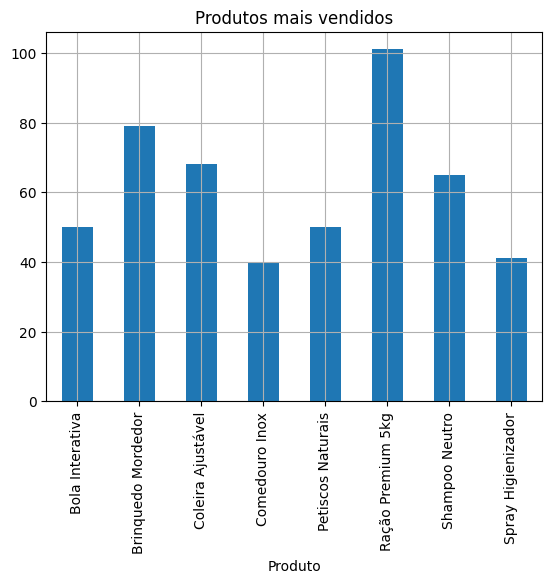

In [158]:
produtos_mais_vendidos = df.groupby('Produto')['Quantidade'].sum()
produtos_mais_vendidos.plot(kind='bar', title='Produtos mais vendidos')
plt.grid()
print(f'O PRODUTO MAIS VENDIDO FOI {produtos_mais_vendidos.idxmax()} COM {produtos_mais_vendidos.max()} VENDAS\n')

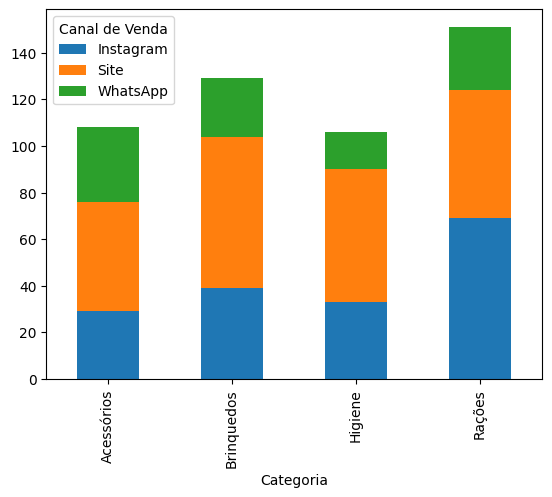

In [159]:
cat_canal = df.groupby(['Categoria', 'Canal de Venda'])['Quantidade'].sum().unstack()
cat_canal.plot(kind='bar', stacked=True)
plt.show()

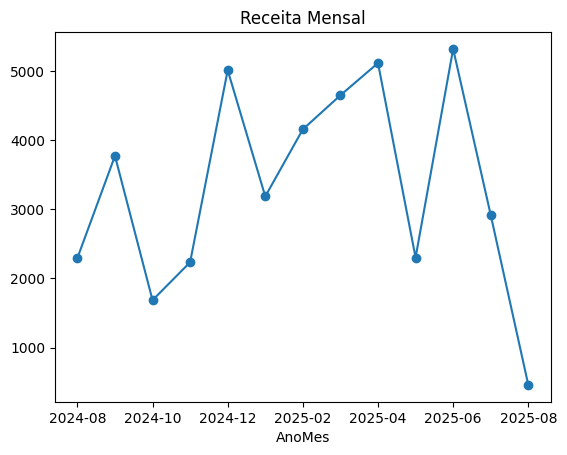

In [160]:
receita_mes = df.groupby('AnoMes')['Valor Total'].sum()
receita_mes.plot(kind='line', marker='o', title='Receita Mensal')
plt.show()

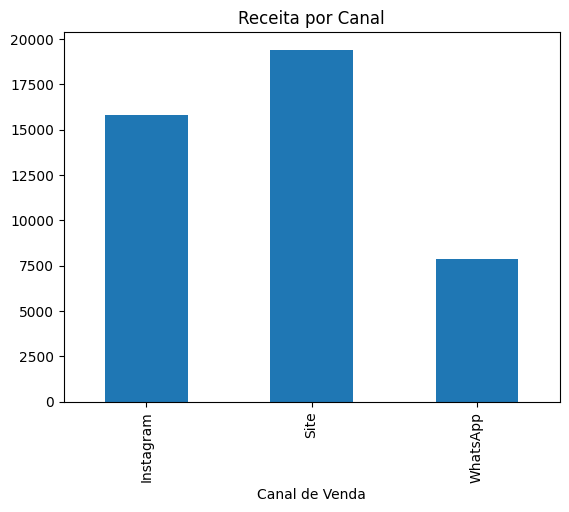

In [161]:
canal_receita = df.groupby('Canal de Venda')['Valor Total'].sum()
canal_receita.plot(kind='bar', title='Receita por Canal')
plt.show()

##Serie temporal com Prophet

In [162]:
df_prophet = df.groupby('Data da Venda')['Valor Total'].sum().reset_index()
df_prophet.rename(columns={'Data da Venda':'ds','Valor Total':'y'}, inplace=True)

In [163]:
modelo = Prophet()
modelo.fit(df_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfx8kylz0/8ayqrb5o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfx8kylz0/0y9odbxl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13684', 'data', 'file=/tmp/tmpfx8kylz0/8ayqrb5o.json', 'init=/tmp/tmpfx8kylz0/0y9odbxl.json', 'output', 'file=/tmp/tmpfx8kylz0/prophet_modelzo6b6g3l/prophet_model-20250809001629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:16:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:16:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [164]:
future = modelo.make_future_dataframe(periods=90)
forecast = modelo.predict(future)

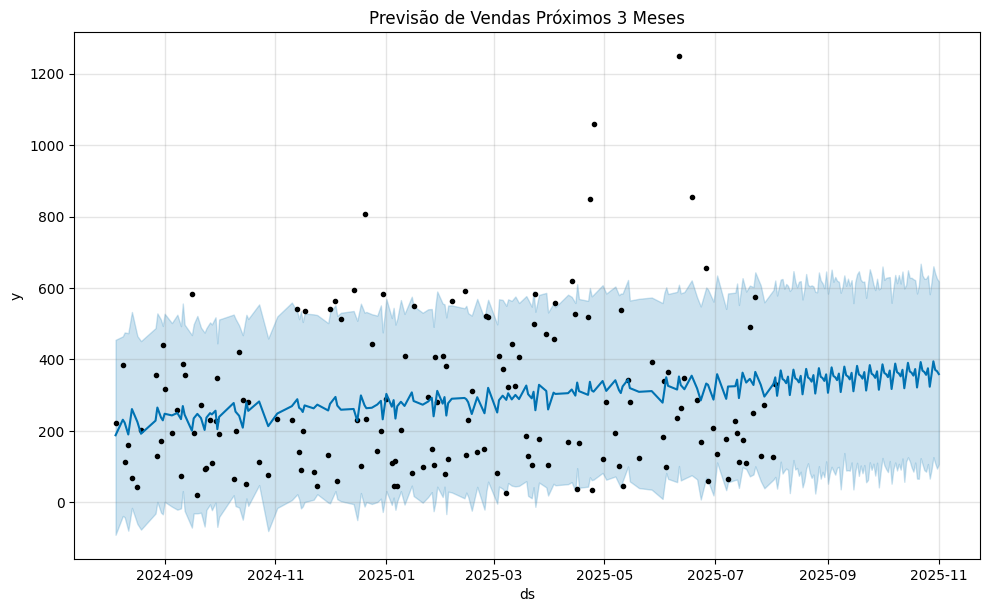

In [165]:
modelo.plot(forecast)
plt.title('Previsão de Vendas Próximos 3 Meses')
plt.show()

##Fazer um Marketing Analytics

In [178]:
ROAS = (df['Valor Total'] / df['Custo de Anúncio'])
df['ROAS'] = ROAS
roas_prod = df.groupby('Produto')['ROAS'].mean()
roas_canal = df.groupby('Canal de Venda')['ROAS'].mean()

In [179]:
corr, pval = pearsonr(df['Custo de Anúncio'], df['Valor Total'])
print(f"Correlação: {corr:.2f}, p-valor: {pval:.4f}")

Correlação: 0.08, p-valor: 0.2482


In [180]:
clientes = df.groupby('Cliente (ID)').agg({
    'Quantidade': 'sum',
    'Valor Total': 'sum'
}).rename(columns={'Quantidade':'Total_Compras','Valor Total':'Total_Gasto'})

clientes['Valor_Médio'] = clientes['Total_Gasto'] / clientes['Total_Compras']

In [181]:
scaler = StandardScaler()
clientes_scaled = scaler.fit_transform(clientes)

In [182]:
kmeans = KMeans(n_clusters=3, random_state=42)
clientes['Cluster'] = kmeans.fit_predict(clientes_scaled)

print(clientes.groupby('Cluster').mean())

         Total_Compras  Total_Gasto  Valor_Médio
Cluster                                         
0             3.931034   201.067241    51.797539
1            12.866667  1173.752667    92.326064
2             4.560976   479.736341   107.103307


In [183]:
site = df[df['Canal de Venda'] == 'Site']['Valor Total']
insta = df[df['Canal de Venda'] == 'Instagram']['Valor Total']

In [184]:
t_stat, p_val = ttest_ind(site, insta, equal_var=False)
print(f"T-Stat: {t_stat:.2f}, P-Valor: {p_val:.4f}")
if p_val < 0.05:
    print("Rejeitamos H0: Existe diferença significativa nas médias.")
else:
    print("Não rejeitamos H0: Não há diferença significativa nas médias.")

T-Stat: 0.07, P-Valor: 0.9462
Não rejeitamos H0: Não há diferença significativa nas médias.


##Growth Marketing e Estratégia

In [185]:
melhor_mes = receita_mes.idxmax()
print(f"Melhor mês: {melhor_mes}")

melhor_canal = roas_canal.idxmax()
print(f"Melhor canal para investir: {melhor_canal}")


Melhor mês: 2025-06
Melhor canal para investir: WhatsApp


In [186]:
df

,Data da Venda,Produto,Categoria,Preço Unitário,Quantidade,Valor Total,Canal de Venda,Custo de Anúncio,Cliente (ID),Ano,Mês,Dia,AnoMes,Lucro Bruto,ROAS
0,2025-04-23,Shampoo Neutro,Higiene,143.59,3,430.78,Site,31.86,Cliente_083,2025,4,23,2025-04,398.92,13.521030
1,2025-01-01,Coleira Ajustável,Acessórios,79.70,1,79.70,Site,36.86,Cliente_022,2025,1,1,2025-01,42.84,2.162235
2,2024-09-29,Brinquedo Mordedor,Brinquedos,113.86,2,227.72,Instagram,13.18,Cliente_021,2024,9,29,2024-09,214.54,17.277693
3,2025-02-24,Shampoo Neutro,Higiene,99.51,1,99.51,Site,18.11,Cliente_059,2025,2,24,2025-02,81.40,5.494754
4,2025-02-15,Spray Higienizador,Higiene,57.98,4,231.92,Instagram,9.08,Cliente_062,2025,2,15,2025-02,222.84,25.541850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2025-06-18,Spray Higienizador,Higiene,111.72,3,335.17,WhatsApp,0.00,Cliente_026,2025,6,18,2025-06,335.17,inf
196,2025-05-10,Brinquedo Mordedor,Brinquedos,60.67,3,182.01,Site,18.38,Cliente_048,2025,5,10,2025-05,163.63,9.902612
197,2024-09-10,Brinquedo Mordedor,Brinquedos,74.83,1,74.83,Site,43.79,Cliente_039,2024,9,10,2024-09,31.04,1.708838
198,2025-04-23,Ração Premium 5kg,Rações,104.52,4,418.09,Instagram,10.43,Cliente_098,2025,4,23,2025-04,407.66,40.085331


###Alguns ROAS estão com "inf", é por causa de alguns estarem com custo médio do anúncio zerado, por não ser maioria, metade ou algo significante, decidir não tirar.